In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext Cython
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import sys,os,glob,h5py
import libstempo as T2
import libstempo.plot as LP

import NX01_psr
import NX01_datafile

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

Msol = 1.98855*10.0**30.0

In [2]:
parentpath = '/Users/staylor/Research/NANOGrav/stochastic_11yr_analysis/data/'

parpath = parentpath + 'partim_no_noise'
timpath = parentpath + 'partim_no_noise'
noisepath = parentpath + 'nano_11_noisefiles_30_marg'

In [3]:
# Find the parfiles and timfiles
parfiles = sorted(glob.glob(parpath+'/*.par'))
timfiles = sorted(glob.glob(timpath+'/*.tim'))

In [4]:
# Find the noise files
noisefiles = sorted(glob.glob(noisepath+'/*.txt'))

In [5]:
len(parfiles), len(timfiles), len(noisefiles)

(45, 45, 45)

## This code block is a one-time deal to make par files stripped of EFACS, EQUADS, and ECORRs (don't do this if you have already got stripped par files)

In [ ]:
stripped_pars = list(parfiles)

In [ ]:
for ii in range(len(stripped_pars)):
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.gls.par', '9yv1.gls.strip.par')
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.t2.gls.par', '9yv1.t2.gls.strip.par')

In [ ]:
for ii in range(len(stripped_pars)):
    os.system('awk \'($1 !~ /T2EFAC/ && $1 !~ /T2EQUAD/ && $1 !~ /ECORR/ && $1 !~ /RNAMP/ && $1 !~ /RNIDX/ ) {{print $0}} \' {0} > {1}'.format(parfiles[ii],stripped_pars[ii]))

In [ ]:
parfiles = sorted(glob.glob(parpath+'/*.strip.par'))

## Now moving on to processing these pulsars

In [6]:
#######################################
# PASSING THROUGH TEMPO2 VIA libstempo
#######################################

t2psr = []
for ii in range(len(parfiles)):
    
    t2psr.append( T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii], 
                                 maxobs=30000, ephem='DE430') )
    
    if np.any(np.isfinite(t2psr[ii].residuals())==False)==True:
        t2psr[ii] = T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii])
                 
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(parfiles))
    sys.stdout.flush()                 

45 of 45


In [ ]:
# Check out some plots if you want
#LP.plotres(t2psr[0])
plt.errorbar(t2psr[0].toas(),t2psr[0].residuals()/1e-6,t2psr[0].toaerrs,fmt='.',alpha=0.2)
plt.xlabel(r'MJD')
plt.ylabel(r'Residuals [$\mu$s]')
plt.show()

In [7]:
## Cell for time-slicing of data

Nyears = 'tot'
Tmin = np.min([np.min(p.toas()) for p in t2psr])
if Nyears == 'tot':
    Tcutoff = np.max([np.max(p.toas()) for p in t2psr])
else:
    Tcutoff = Tmin + Nyears*365.25

ind_slice = []
for ii,p in enumerate(t2psr):
    
    mask = np.logical_and(p.toas() >= Tmin, p.toas() <= Tcutoff)
    
    if np.sum(mask) > 0:
        Tobs = (p.toas()[mask].max() - p.toas()[mask].min()) / 365.25
        
        if Tobs > 1.0:
            ind_slice.append(ii)

In [8]:
# Pass all tempopulsar objects to NX01 pulsar class
psr = [NX01_psr.PsrObj(t2psr[ii]) for ii in ind_slice]
[p.grab_all_vars(jitterbin=1.0,makeGmat=False,
                 fastDesign=False,planetssb=True,
                 startMJD=Tmin, endMJD=Tcutoff) for p in psr] # according to the 9 year paper,
                                                              # the jitterbin used is 1s

--> Processing B1855+09
--> Grabbed the planet position-vectors at the pulsar timestamps.
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Performing SVD of design matrix for stabilization...
--> Done reading in pulsar :-) 

--> Processing B1937+21
--> Grabbed the planet position-vectors at the pulsar timestamps.
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Performing SVD of design matrix for stabilization...
--> Done reading in pulsar :-) 

--> Processing B1953+29
--> Grabbed the planet position-vectors at the pul

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
# Pass all tempopulsar objects to NX01 pulsar class
#psr = [NX01_psr.PsrObj(p) for p in t2psr]
#[p.grab_all_vars(jitterbin=1.0,makeGmat=False,
#                 fastDesign=False,planetssb=True,
#                 startMJD=Tmin, endMJD=Tcutoff) for p in psr] # according to the 9 year paper,
#                                                              # the jitterbin used is 1s

In [9]:
# Fill in the locations of par, tim, and noise files
for ii,jj in enumerate(ind_slice):
    psr[ii].parfile = parfiles[jj] 
    psr[ii].timfile = timfiles[jj]
    psr[ii].noisefile = noisefiles[jj]

In [10]:
# Make HDF5 file directory
dirname = os.getcwd() + '/11yr_psr_hdf5_files/DE430/tm_svdstabilized/'
if not os.path.exists(dirname):
    os.makedirs(dirname)

In [11]:
# Dump all pulsars into HDF5 files 
for ii,p in enumerate(psr):
    df = NX01_datafile.DataFile(dirname + '/' + p.name + '.hdf5')
    df.addTempoPulsar(p)
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(psr))
    sys.stdout.flush()

45 of 45


In [12]:
# Create information text file for pulsar hdf5 file locations
fil = open(dirname + '/psrList_nano11yr.txt','w')
print >>fil, "NAME", "HDF5-PATH", "PARFILE-PATH", "TIMFILE-PATH"
print >>fil, "#############################################"
for p in psr:
    print >>fil, p.name, dirname+'/'+p.name+'.hdf5'
fil.close()

In [13]:
rankings = np.genfromtxt(parentpath+'psrlist.txt',dtype=str)
fil = open(dirname + '/psrList_nano11_ranked.txt','w')
print >>fil, "NAME", "HDF5-PATH", "PARFILE-PATH", "TIMFILE-PATH"
print >>fil, "#############################################"
for p in rankings:
    print >>fil, p, dirname+'/'+p+'.hdf5'
fil.close()

In [14]:
rankings = np.genfromtxt(parentpath+'psrlist_Tg3yr.txt',dtype=str)
fil = open(dirname + '/psrList_nano11_ranked_Tg3yr.txt','w')
print >>fil, "NAME", "HDF5-PATH", "PARFILE-PATH", "TIMFILE-PATH"
print >>fil, "#############################################"
for p in rankings:
    print >>fil, p, dirname+'/'+p+'.hdf5'
fil.close()

## DE430 Savage-Dickey Bayes factors

In [2]:
chain_varyslope = np.loadtxt('./chains_nano11_de430/pta_gwbloguniform_noCorr_gamVary_redloguniformpowerlawnm30/chain_1.0.txt')
chain_fixslope = np.loadtxt('./chains_nano11_de430/pta_gwbloguniform_noCorr_gam4p33_redloguniformpowerlawnm30/chain_1.0.txt')

In [3]:
params = np.loadtxt('./chains_nano11_de430/pta_gwbloguniform_noCorr_gam4p33_redloguniformpowerlawnm30/parameter_list.txt',dtype=str)

In [4]:
params

array([['0', 'Ared_J1713+0747'],
       ['1', 'Ared_J1909-3744'],
       ['2', 'Ared_J1640+2224'],
       ['3', 'Ared_J1600-3053'],
       ['4', 'Ared_J2317+1439'],
       ['5', 'Ared_J1918-0642'],
       ['6', 'Ared_J1744-1134'],
       ['7', 'Ared_J0030+0451'],
       ['8', 'Ared_J0613-0200'],
       ['9', 'Ared_J1614-2230'],
       ['10', 'Ared_B1855+09'],
       ['11', 'Ared_J1853+1303'],
       ['12', 'Ared_J2145-0750'],
       ['13', 'Ared_J1455-3330'],
       ['14', 'Ared_J1012+5307'],
       ['15', 'Ared_J1741+1351'],
       ['16', 'Ared_J2010-1323'],
       ['17', 'Ared_J1024-0719'],
       ['18', 'gam_red_J1713+0747'],
       ['19', 'gam_red_J1909-3744'],
       ['20', 'gam_red_J1640+2224'],
       ['21', 'gam_red_J1600-3053'],
       ['22', 'gam_red_J2317+1439'],
       ['23', 'gam_red_J1918-0642'],
       ['24', 'gam_red_J1744-1134'],
       ['25', 'gam_red_J0030+0451'],
       ['26', 'gam_red_J0613-0200'],
       ['27', 'gam_red_J1614-2230'],
       ['28', 'gam_red_B1855+0

In [5]:
chain_varyslope.shape, chain_fixslope.shape

((474800, 42), (477400, 41))

In [7]:
burn = int(1e5)
ind = 36

In [8]:
import acor

In [9]:
ac_length, chain_mean, chain_std = acor.acor(chain_fixslope[burn:,ind])

In [10]:
ac_length

31.0039720809027

In [28]:
## Trialing the bin size

prior = 1./7.
dA = np.linspace(0.01,0.1,100)

bf = []
bf_err = []
mask = []
for ii,delta in enumerate(dA):
    
    n = np.sum(chain_varyslope[burn:,ind] <= (-18.0 + delta))
    N = chain_varyslope[burn:,ind].shape[0]
    
    post = n / N / delta
    
    print n
        
    bf.append( prior / post)
    bf_err.append( bf[ii] / np.sqrt(n) )
    
    if n > 200:
        mask.append(ii)

57
58
66
75
78
84
90
94
97
98
102
108
116
119
129
133
144
145
155
175
182
188
192
201
205
216
222
224
232
246
248
258
267
274
283
289
301
310
311
313
321
332
334
340
349
350
353
366
387
390
408
415
416
418
419
419
424
431
431
435
439
445
451
453
459
460
475
481
486
488
499
515
521
525
530
534
542
550
551
553
559
571
583
584
587
590
601
611
622
641
644
648
659
664
667
669
671
680
684
690


In [29]:
mean = np.mean(np.array(bf)[mask])
print mean

7.78851080721


In [30]:
np.std(np.array(bf)[mask]), mean - np.array(bf)[mask].min(), mean - np.array(bf)[mask].max()

(0.19575546978053487, 0.51653459065282981, -0.52191047882368213)

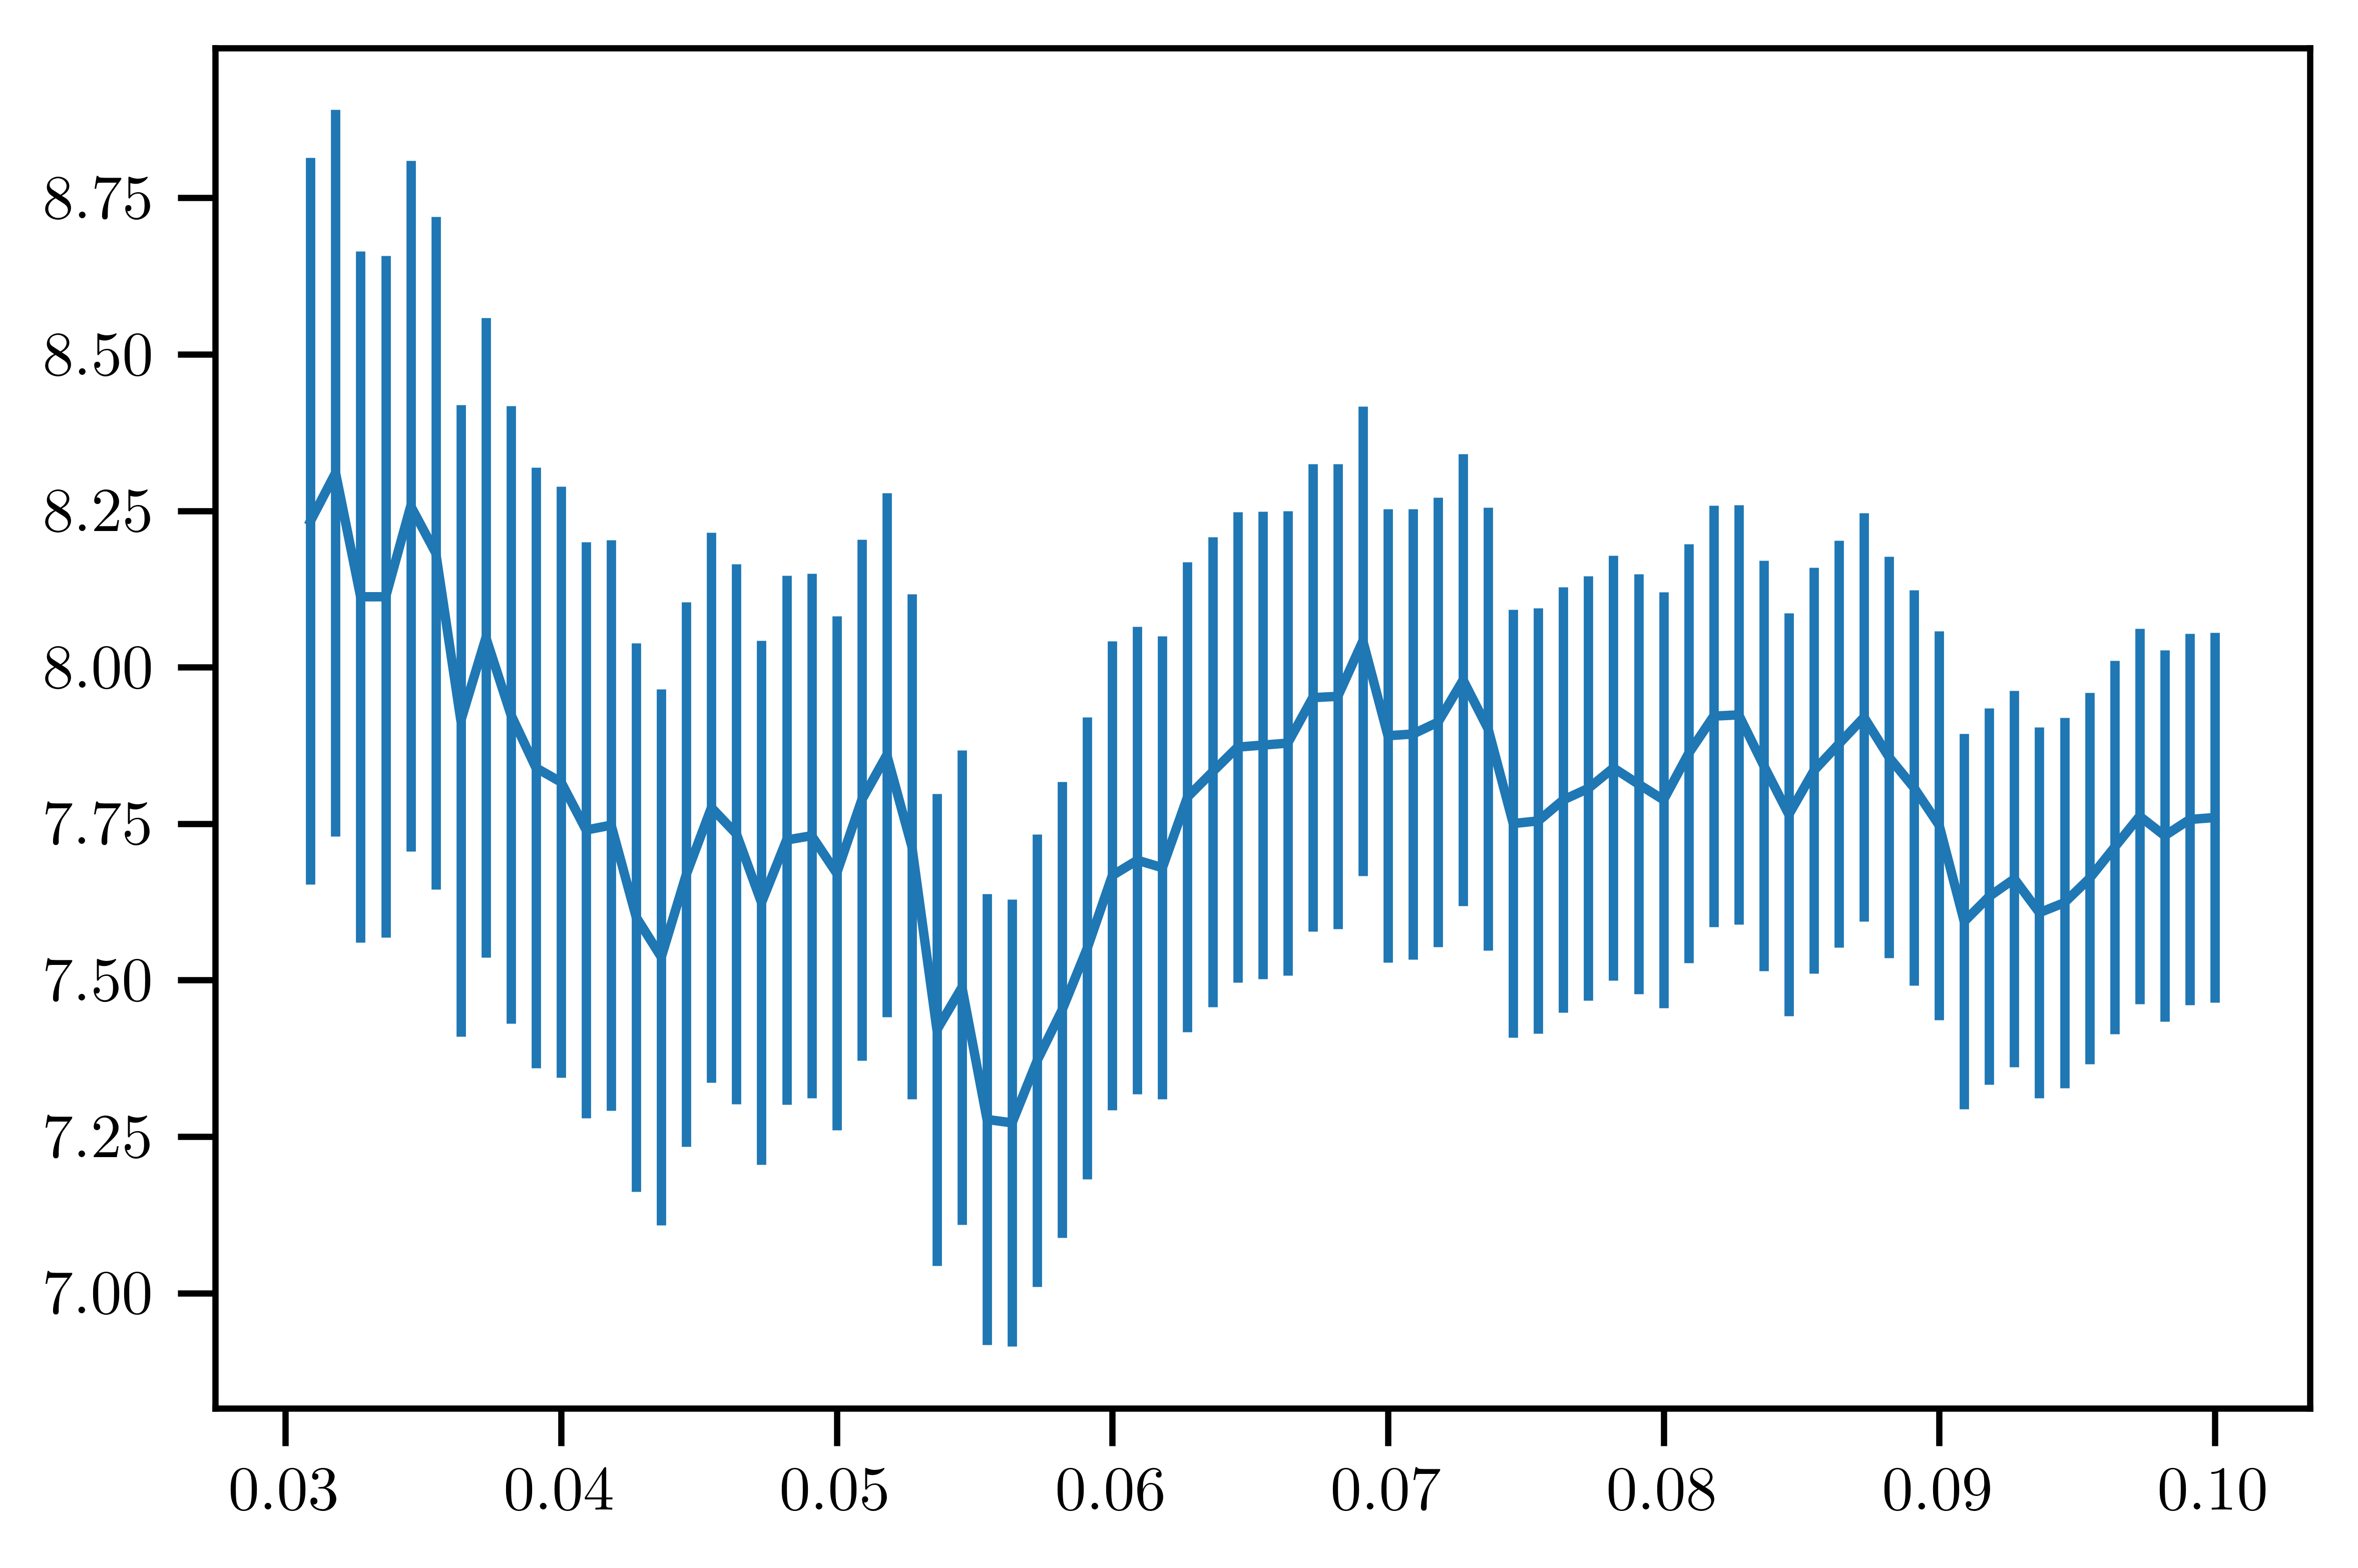

In [31]:
plt.errorbar(dA[mask], np.array(bf)[mask], np.array(bf_err)[mask])
plt.show()

In [15]:
chain_fixslope = np.loadtxt('./chains_nano11_de430_tmsvdstabilized/pta_gwbloguniform_noCorr_gam4p33_redloguniformpowerlawnm30/chain_1.0.txt')

In [16]:
chain_fixslope.shape

(4300, 73)

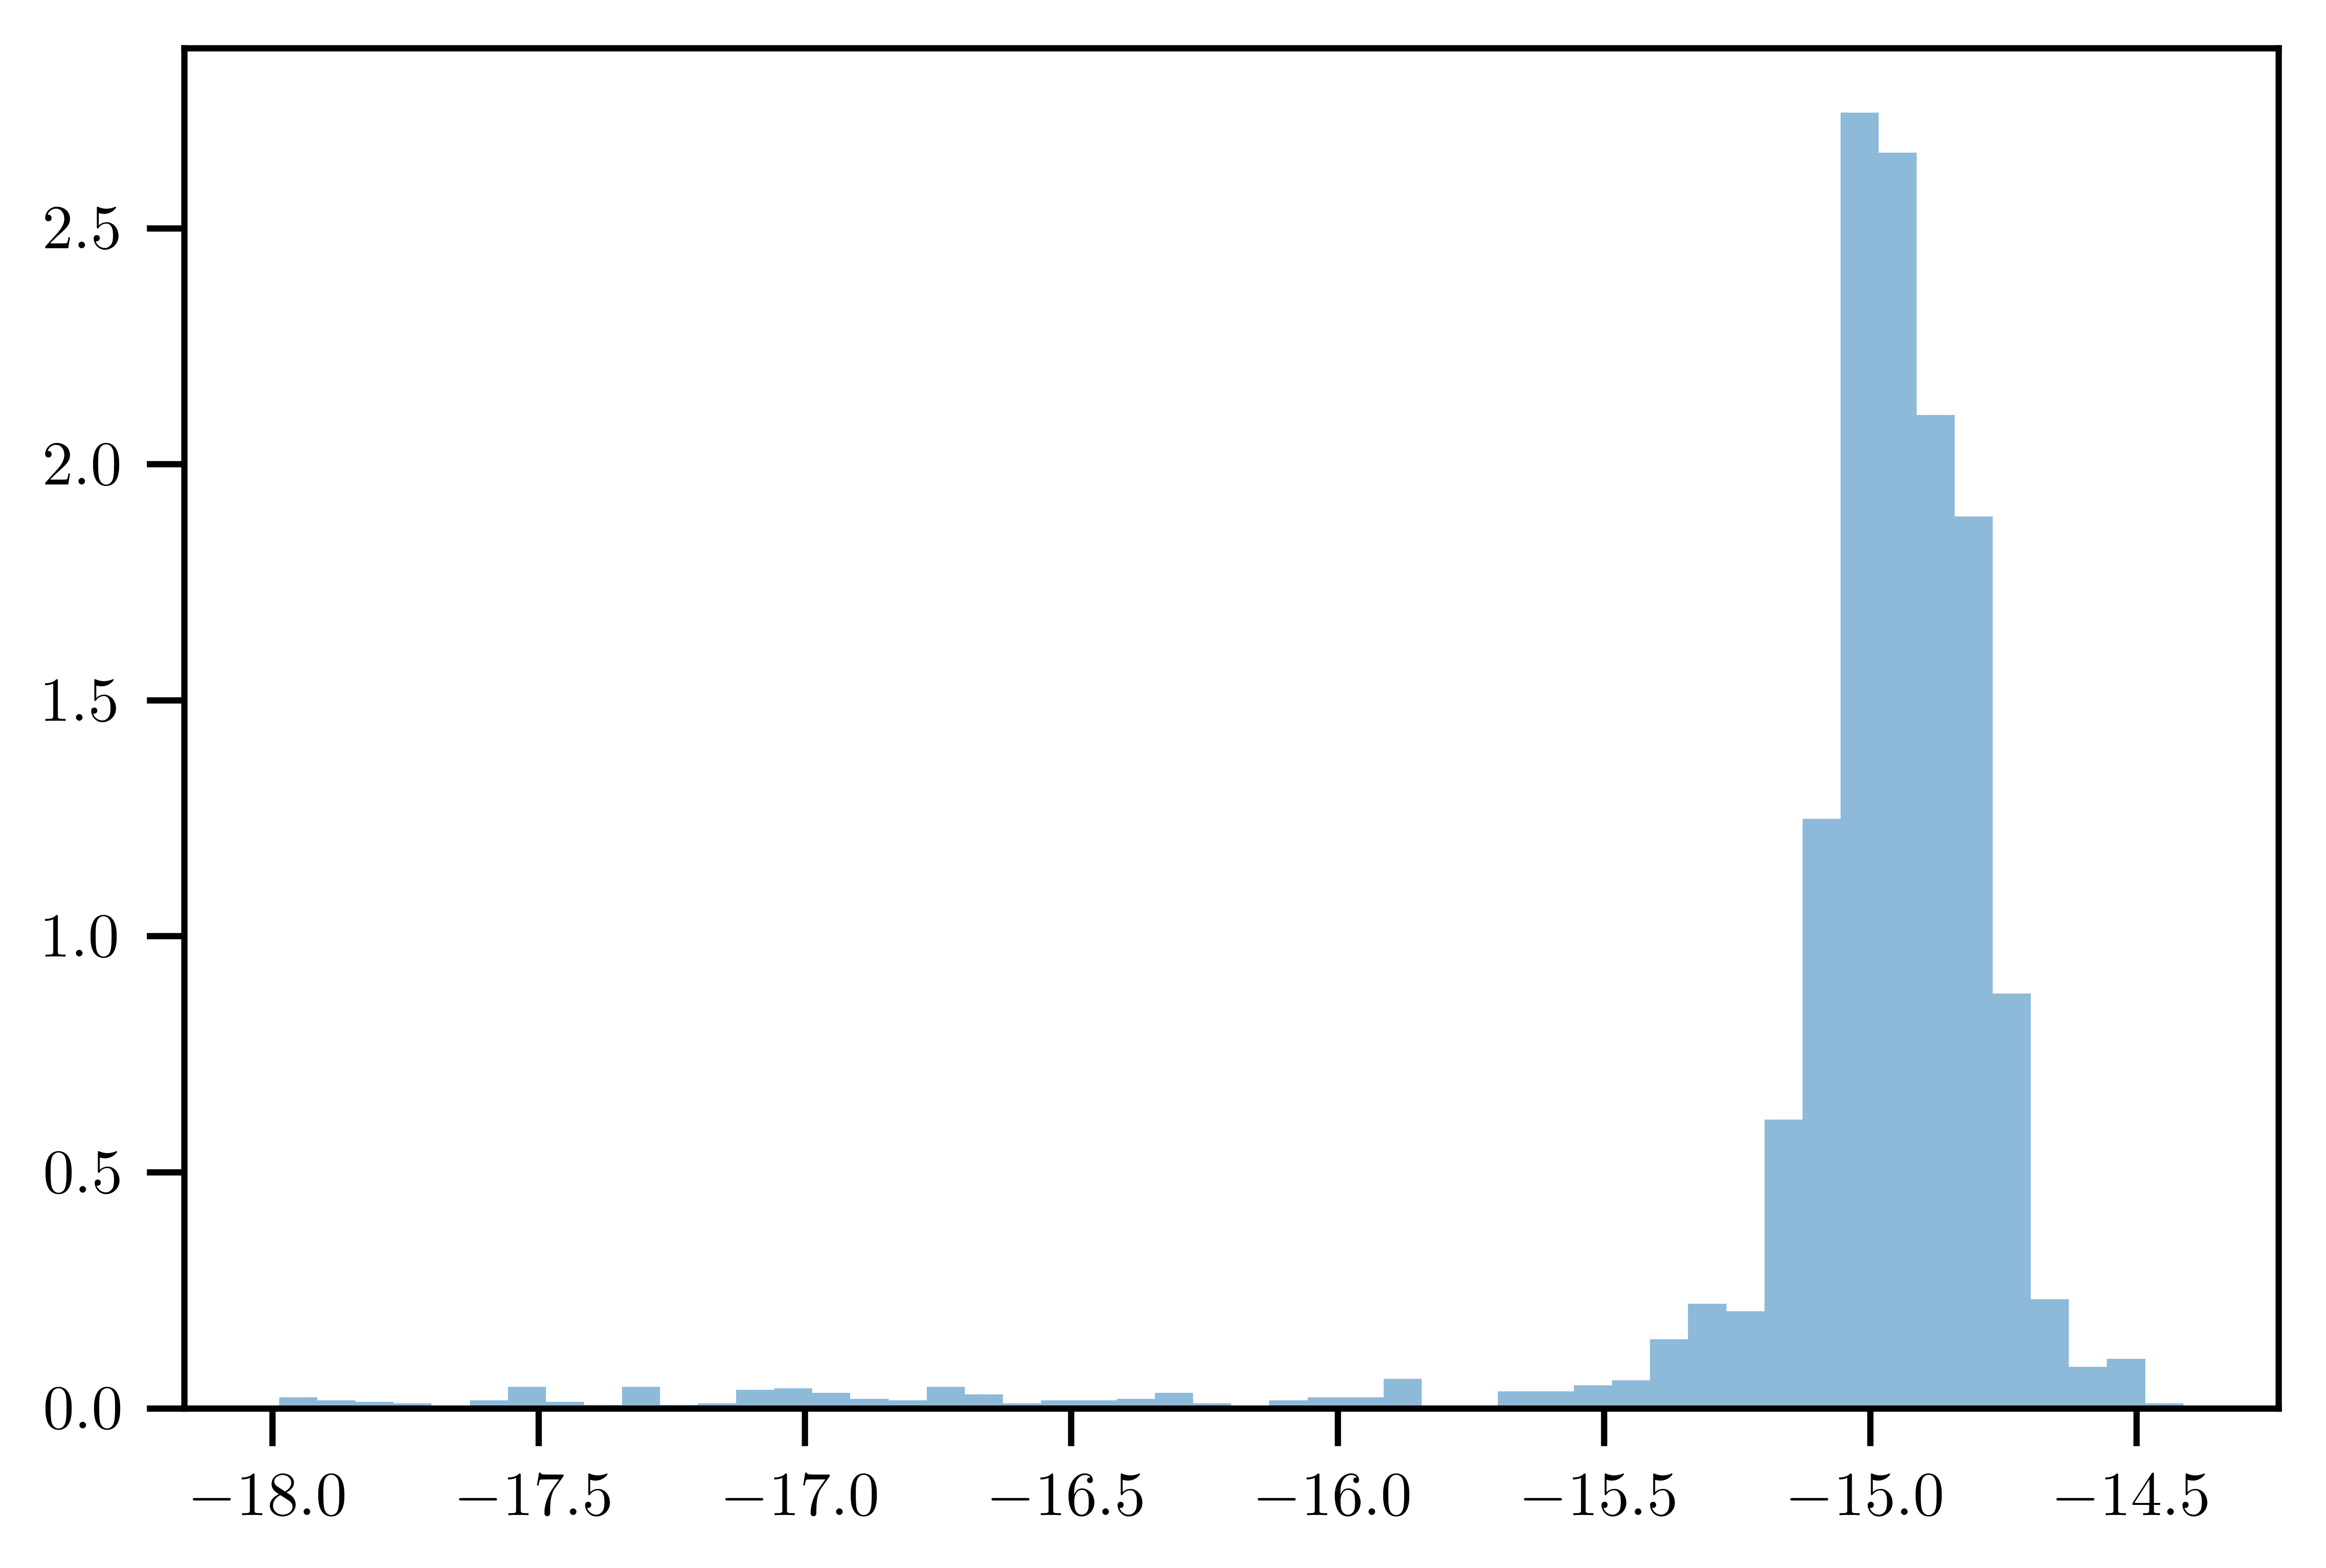

In [19]:
n, _, _ = plt.hist(chain_fixslope[:,68], 50, normed=1, alpha=0.5)